# ISPR 2025 - Midterm 3 - Assignament 2 - Gianluca Panzani (550358)

In [350]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms

## Util methods

In [351]:
def get_img(img_dir: str, prefix: str, index: int, postfix: str, mask=False) -> Image:
    zeros = '00' if index < 10 else '0' if index < 100 else ''
    full_path = f'{img_dir}{prefix}{zeros}{index}{postfix}'
    if not mask:
        return Image.open(full_path).convert('RGB')
    return Image.open(full_path).convert('L')

def from_img_to_tensor(img: Image, resize_shape: tuple, mean=None, std=None) -> torch.Tensor:
    if mean is not None and std is not None:
        if not (len(mean) == 3 and len(std) == 3):
            raise ValueError('The image has 3 channles. The parameters "mean" and "std" have to be lists with length equal to 3.')
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor(), # Scaling
            transforms.Normalize(mean, std) # Normalization
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor() # Scaling
        ])
    return transform(img)
    
def from_mask_to_tensor(img: Image, resize_shape: tuple) -> torch.Tensor:
    img = img.resize(resize_shape, resample=Image.NEAREST)
    img_np = np.array(img)
    if img_np.max() > 1:
        img_np = (img_np > 127).astype(np.uint8)
    tensor = torch.from_numpy(img_np).float().unsqueeze(0)  # shape: [1, H, W]
    return tensor

def get_mean_and_std(images_dir: str, img_prefix: str, img_postfix: str, resize_shape: tuple):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    i = 0
    while True:
        i += 1
        try:
            image = get_img(img_dir=images_dir, prefix=img_prefix, index=i, postfix=img_postfix, mask=False)
        except:
            break
        img = from_img_to_tensor(img=image, resize_shape=resize_shape)
        mean += img.mean(dim=(1, 2)) # Mean computed on each channel (e.g. with RGB -> [meanR,meanG,meanB])
        std += img.std(dim=(1, 2)) # Std computed on each channel (e.g. with RGB -> [stdR,stdG,stdB])
    mean = (mean / (i-1)).tolist()
    std = (std / (i-1)).tolist()
    return mean, std

## Dataset class definition

In [ ]:
class HorseSegmentationDataset(Dataset):
    def __init__(self, images_dir, img_prefix, img_postfix, masks_dir, mask_prefix, mask_postfix, resize_shape=(128,128)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.resize_shape = resize_shape
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.img_postfix = img_postfix
        self.mask_postfix = mask_postfix
        self.length = len(os.listdir(images_dir))
        mean, std = get_mean_and_std(
            images_dir=self.images_dir,
            img_prefix=self.img_prefix,
            img_postfix=self.img_postfix,
            resize_shape=self.resize_shape
        )
        self.mean = mean
        self.std = std

    def __getitem__(self, index):
        img = get_img(self.images_dir, self.img_prefix, index+1, self.img_postfix, mask=False)
        mask = get_img(self.masks_dir, self.mask_prefix, index+1, self.mask_postfix, mask=True)
        img_tensor = from_img_to_tensor(img, self.resize_shape, self.mean, self.std)
        mask_tensor = from_mask_to_tensor(mask, self.resize_shape)
        return img_tensor, mask_tensor
    
    def __len__(self):
        return self.length



# Creation of the dataset object
horse_dataset = HorseSegmentationDataset(
    images_dir='weizmann_horse_db/horse/',
    img_prefix='horse',
    img_postfix='.png',
    masks_dir='weizmann_horse_db/mask/',
    mask_prefix='horse',
    mask_postfix='.png',
    resize_shape=(128,128)
)

In [353]:
class SegmentationCNN(nn.Module):
    def __init__(self,
                 encoder_channels: list[int],
                 decoder_channels: list[int],
                 encoder_kernel_sizes: list[int],
                 decoder_kernel_sizes: list[int],
                 encoder_strides: list[int],
                 decoder_strides: list[int],
                 output_padding: int):
        super(SegmentationCNN, self).__init__()
        # Encoder architecture
        layers = []
        for i in range(len(encoder_channels)-1):
            k = encoder_kernel_sizes[i]
            s = encoder_strides[i]
            layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=k, stride=s, padding=k//2))
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)
        # Decoder architecture
        layers = []
        for i in range(len(decoder_channels)-2):
            k = decoder_kernel_sizes[i]
            s = decoder_strides[i]
            layers.append(nn.ConvTranspose2d(decoder_channels[i], decoder_channels[i+1], kernel_size=k, stride=s, padding=k//2, output_padding=output_padding))
            layers.append(nn.ReLU())
        layers.append(nn.ConvTranspose2d(decoder_channels[-2], decoder_channels[-1], kernel_size=decoder_kernel_sizes[-1], stride=decoder_strides[-1]))
        layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return x
    



class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128], kernel_size=3, activation='relu'):
        super(UNet, self).__init__()
        # Initializations
        self.kernel_size = kernel_size
        self.activation = activation
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        # Encoder
        for feature in features:
            self.encoders.append(self._convolutional_block(in_channels, feature))
            in_channels = feature
        # Bottleneck
        self.bottleneck = self._convolutional_block(features[-1], 2*features[-1])
        # Decoder
        in_channels = 2*features[-1]
        for feature in features[::-1]: # Invert the list and skip the last feature for the bottleneck
            self.decoders.append(nn.ConvTranspose2d(in_channels, feature, kernel_size=2, stride=2))
            self.decoders.append(self._convolutional_block(2*feature, feature))
            in_channels = feature
        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):

        # Encoding
        skip_connections = []
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.bottleneck(x)

        # Decoding
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.decoders), 2):
            block1_index = i
            block2_index = i+1
            # Transposed Convolutional block
            x = self.decoders[block1_index](x)
            # Case of interpolation
            x_skip = skip_connections[i//2]
            if x.shape != x_skip.shape:
                x = F.interpolate(x, size=x_skip.shape[2:])
            x = torch.cat((x_skip, x), dim=1)
            # Convolutional block
            x = self.decoders[block2_index](x)

        # Final convolution
        x = self.final_conv(x)
        return torch.sigmoid(x)

    def _convolutional_block(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, padding=self.kernel_size//2),
            self._get_activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, padding=self.kernel_size//2),
            self._get_activation(),
        ]
        return nn.Sequential(*layers)

    def _get_activation(self):
        if self.activation == 'relu':
            return nn.ReLU(inplace=True)
        elif self.activation == 'leaky_relu':
            return nn.LeakyReLU(inplace=True)
        else:
            raise ValueError(f'Unsupported activation: {self.activation}')

## Training method

The train method is divided into training and validation phase, in which are computed: the loss on the Training set, the loss on the Validation set and the Intersection over Union (IoU) score.

IoU measures the overlap between the predicted mask and actual mask, and is commonly used as accuracy metric in segmentation tasks.

In [ ]:
def iou(preds: torch.Tensor, masks: torch.Tensor) -> float:
    '''
    Computes the Intersection over Union (IoU) score between the predicted masks and the actual masks.

    Parameters:
    - preds: the predicted masks (output of the model).
    - masks: the actual masks (ground truth).

    Returns:
    - iou_score: the IoU score.
    '''
    preds = (preds > 0.5).float()
    masks = (masks > 0.5).float()
    # Compute intersection and union
    intersection = (preds * masks).sum()
    union = ((preds + masks) > 0).float().sum()
    # Case of empty union (the predictions and the masks are empty, so equal)
    if union == 0:
        return 1.0
    iou_score = intersection / union
    return iou_score.item()



def train(model: nn.Module, tr_dataloader: DataLoader, vl_dataloader: DataLoader, optimizer, criterion, device, epochs, threshold, tolerance, verbose=1):
    '''
    Performs the training of the model.

    Parameters:
    - model: the model to train.
    - tr_dataloader: the training set.
    - vl_dataloader: the validation set.
    - optimizer: the optimizer to use.
    - criterion: the loss function to use.
    - device: the device to use (CPU or GPU).
    - epochs: the number of epochs.
    - threshold: the threshold to use for early stopping.
    - tolerance: the number of epochs of tolerance for early stopping.
    - verbose: the verbosity level (0 = no output, 1 = output every epoch).

    Returns:
    - tr_losses: the training losses list.
    - vl_losses: the validation losses list.
    - iou_scores: the IoU scores list.
    '''
    model.to(device)

    # Initializations
    k = 5
    patience = 0
    best_mean_iou_avg_score = 0
    tr_losses = []
    vl_losses = []
    iou_scores = []

    # Iterate on the epochs
    for epoch in range(epochs):

        # Start Training phase
        model.train()
        total_loss = 0.0
        for imgs, masks in tr_dataloader:
            imgs = imgs.to(device)          # Move images' tensors on GPU or CPU
            masks = masks.to(device)        # Move masks' tensors on GPU or CPU

            preds = model(imgs)             # Compute the predictions
            loss = criterion(preds, masks)  # Compute the loss
            optimizer.zero_grad()           # Reset the gradients
            loss.backward()                 # Perform backpropagation
            optimizer.step()                # Update model's parameters (based on gradients)

            total_loss += loss.item()       # Update total loss with the average loss on this batch

        tr_avg_loss = total_loss / len(tr_dataloader)
        tr_losses.append(tr_avg_loss)

        # Start Validation phase
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            total_iou = 0.0

            for imgs, masks in vl_dataloader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                preds = model(imgs)
                loss = criterion(preds, masks)

                total_loss += loss.item()
                total_iou += iou(preds, masks)

        vl_avg_loss = total_loss / len(vl_dataloader)
        vl_losses.append(vl_avg_loss)
        iou_avg_score = total_iou / len(vl_dataloader)
        iou_scores.append(iou_avg_score)

        # Print of the epoch result
        if verbose > 0:
            print(f'Epoch {epoch+1}/{epochs}: TR_loss={tr_avg_loss:.4f} - VL_loss={vl_avg_loss:.4f} - IoU={iou_avg_score:.4f}')
        
        # Early stopping (based on IoU score)
        current_mean_iou_avg_score = np.mean(iou_scores[-k:])
        if epoch > k and abs(current_mean_iou_avg_score - best_mean_iou_avg_score) < threshold:
            patience += 1
        else:
            patience = 0
        if patience > tolerance:
            if verbose > 0:
                print(f'Early stopping at epoch {epoch+1}')
            break
        if best_mean_iou_avg_score < current_mean_iou_avg_score:
            best_mean_iou_avg_score = current_mean_iou_avg_score
    
    return tr_losses, vl_losses, iou_scores

## Grid search
The best hyperparameters are searched with the Grid search technique.

In [ ]:
def get_params_combinations(params: dict) -> list[dict]:
    '''
    Creates and saves into the class instance a list with all the possible combinations of parameters \
    in the dictionary "params".

    Parameters:
    - params: dictionary with the parameters as associations <key:values> (with: key=parameter_name,
    values=possible_values_list).

    Returns:
    A list of dictionaries such that each one represents a combination of parameters (1 combination = 1 dictionary).
    '''
    params_index_dict = {}
    params_combinations = []
    for key in params.keys():
        params_index_dict[key] = 0 # current_index for that key
    while sum([index+1 for _, index in params_index_dict.items()]) != sum(len(val_list) for _, val_list in params.items()):
        params_i = {}
        for key, i in params_index_dict.items():
            params_i[key] = params[key][i]
        params_combinations.append(params_i)
        for key in params_index_dict.keys():
            params_index_dict[key] += 1
            if params_index_dict[key] < len(params[key]):
                break
            params_index_dict[key] = 0
    params_i = {}
    for key, i in params_index_dict.items():
        params_i[key] = params[key][i]
    params_combinations.append(params_i)
    return params_combinations


# Space of the hyperparameters
params_space = {
    'batch_size': [16, 32, 64],
    'learning_rate': [0.0001, 0.001],
    'epochs': [75],
    'threshold': [0.0001],
    'tolerance': [10],
    'architecture': [
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,3], 'encoder_strides': [2,2,2],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [3,3,3], 'decoder_strides': [2,2,2],
            'output_padding': 1
        },
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,5], 'encoder_strides': [2,2,1],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [5,3,3], 'decoder_strides': [1,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128], 'encoder_kernel_sizes': [3,3,3,3], 'encoder_strides': [2,2,2,1],
            'decoder_channels': [128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3], 'decoder_strides': [1,2,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128,256], 'encoder_kernel_sizes': [3,3,3,3,3], 'encoder_strides': [2,2,2,2,1],
            'decoder_channels': [256,128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3,3], 'decoder_strides': [1,2,2,2,2],
            'output_padding': 0
        }
    ]
}
params_space = {
    'batch_size': [8, 16],
    'learning_rate': [0.0001, 0.001],
    'epochs': [150],
    'threshold': [0.001],
    'tolerance': [5],
    'activation': ['relu', 'leaky_relu'],
    'kernel_size': [3, 5],
    'features': [[32, 64, 128], [32, 64, 128, 256]]
}

## Model selection

Hyperparameters [1/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.6628 - VL_loss=0.6545 - IoU=0.0000
Epoch 2/100: TR_loss=0.6155 - VL_loss=0.5778 - IoU=0.0000
Epoch 3/100: TR_loss=0.5535 - VL_loss=0.5370 - IoU=0.0000
Epoch 4/100: TR_loss=0.4869 - VL_loss=0.4588 - IoU=0.0000
Epoch 5/100: TR_loss=0.4096 - VL_loss=0.3927 - IoU=0.0000
Epoch 6/100: TR_loss=0.3652 - VL_loss=0.3449 - IoU=0.5220
Epoch 7/100: TR_loss=0.3270 - VL_loss=0.3160 - IoU=0.5878
Epoch 8/100: TR_loss=0.3167 - VL_loss=0.2975 - IoU=0.6098
Epoch 9/100: TR_loss=0.2942 - VL_loss=0.3032 - IoU=0.6185
Epoch 10/100: TR_loss=0.2902 - VL_loss=0.2972 - IoU=0.5860
Epoch 11/100: TR_loss=0.2914 - VL_loss=0.2737 - IoU=0.6246
Epoch 12/100: TR_loss=0.2716 - VL_loss=0.3013 - IoU=0.6271
Epoch 13/100: TR_loss=0.2656 - VL_loss=0.2839 - IoU=0.6103
Epoch 14/100: TR_loss=0.2571 - VL_loss=0.2504 - IoU=0.658

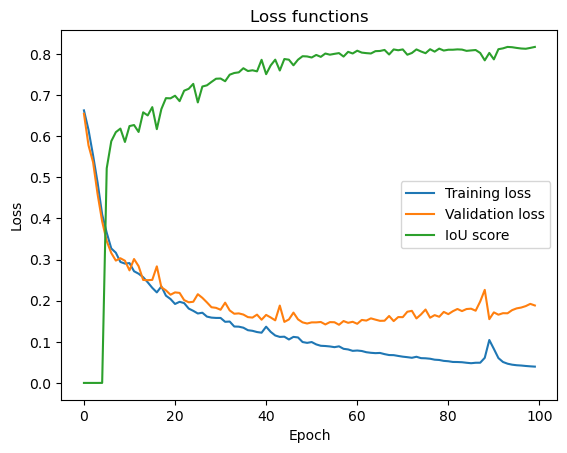


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8148169602666583
- Loss=0.18833876933370317
Hyperparameters [2/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.6808 - VL_loss=0.6761 - IoU=0.0000
Epoch 2/100: TR_loss=0.6673 - VL_loss=0.6478 - IoU=0.0000
Epoch 3/100: TR_loss=0.6084 - VL_loss=0.5810 - IoU=0.0000
Epoch 4/100: TR_loss=0.5648 - VL_loss=0.5519 - IoU=0.0000
Epoch 5/100: TR_loss=0.5461 - VL_loss=0.5274 - IoU=0.0000
Epoch 6/100: TR_loss=0.5177 - VL_loss=0.4932 - IoU=0.0124
Epoch 7/100: TR_loss=0.4723 - VL_loss=0.4506 - IoU=0.1878
Epoch 8/100: TR_loss=0.4423 - VL_loss=0.4214 - IoU=0.3546
Epoch 9/100: TR_loss=0.4081 - VL_loss=0.3798 - IoU=0.4716
Epoch 10/100: TR_loss=0.3690 - VL_loss=0.3

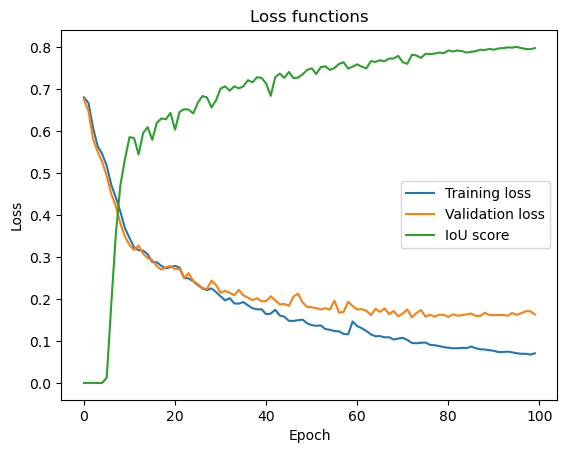


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8148169602666583
- Loss=0.18833876933370317
Hyperparameters [3/24]: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.6747 - VL_loss=0.6707 - IoU=0.0000
Epoch 2/100: TR_loss=0.6660 - VL_loss=0.6613 - IoU=0.0000
Epoch 3/100: TR_loss=0.6521 - VL_loss=0.6445 - IoU=0.0000
Epoch 4/100: TR_loss=0.6287 - VL_loss=0.6002 - IoU=0.0000
Epoch 5/100: TR_loss=0.5855 - VL_loss=0.5768 - IoU=0.0000
Epoch 6/100: TR_loss=0.5613 - VL_loss=0.5647 - IoU=0.0000
Epoch 7/100: TR_loss=0.5619 - VL_loss=0.5541 - IoU=0.0000
Epoch 8/100: TR_loss=0.5344 - VL_loss=0.5459 - IoU=0.0000
Epoch 9/100: TR_loss=0.5345 - VL_loss=0.5331 - IoU=0.0000
Epoch 10/100: TR_loss=0.5085 - VL_loss=0.5

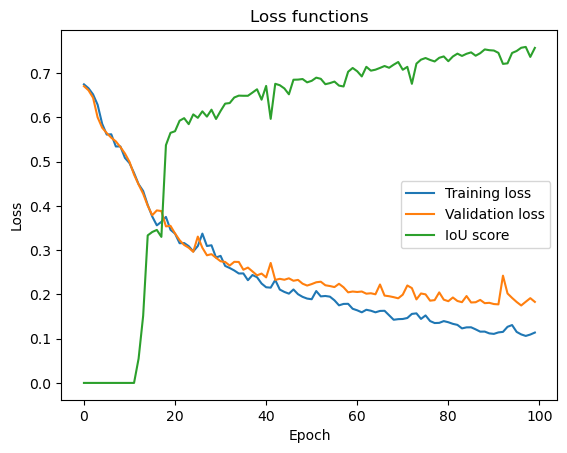


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8148169602666583
- Loss=0.18833876933370317
Hyperparameters [4/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.5554 - VL_loss=0.4702 - IoU=0.0000
Epoch 2/100: TR_loss=0.4423 - VL_loss=0.4139 - IoU=0.3913
Epoch 3/100: TR_loss=0.4206 - VL_loss=0.4509 - IoU=0.4616
Epoch 4/100: TR_loss=0.3756 - VL_loss=0.3928 - IoU=0.5283
Epoch 5/100: TR_loss=0.3249 - VL_loss=0.3198 - IoU=0.5881
Epoch 6/100: TR_loss=0.3070 - VL_loss=0.3170 - IoU=0.6003
Epoch 7/100: TR_loss=0.2661 - VL_loss=0.2955 - IoU=0.6348
Epoch 8/100: TR_loss=0.2618 - VL_loss=0.2831 - IoU=0.6384
Epoch 9/100: TR_loss=0.2498 - VL_loss=0.2521 - IoU=0.6615
Epoch 10/100: TR_loss=0.2242 - VL_loss=0.268

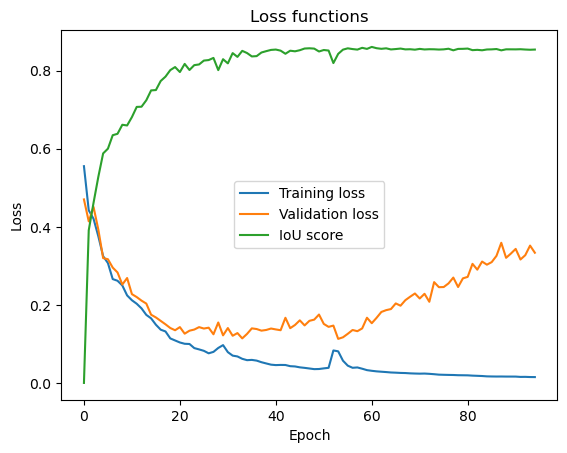


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [5/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.5958 - VL_loss=0.5456 - IoU=0.0000
Epoch 2/100: TR_loss=0.5361 - VL_loss=0.4795 - IoU=0.2979
Epoch 3/100: TR_loss=0.4723 - VL_loss=0.4739 - IoU=0.4212
Epoch 4/100: TR_loss=0.4460 - VL_loss=0.4538 - IoU=0.4641
Epoch 5/100: TR_loss=0.4372 - VL_loss=0.4674 - IoU=0.4290
Epoch 6/100: TR_loss=0.4316 - VL_loss=0.4343 - IoU=0.5006
Epoch 7/100: TR_loss=0.4624 - VL_loss=0.4030 - IoU=0.5249
Epoch 8/100: TR_loss=0.4436 - VL_loss=0.4771 - IoU=0.4382
Epoch 9/100: TR_loss=0.4193 - VL_loss=0.3463 - IoU=0.5801
Epoch 10/100: TR_loss=0.4557 - VL_loss=0.4982

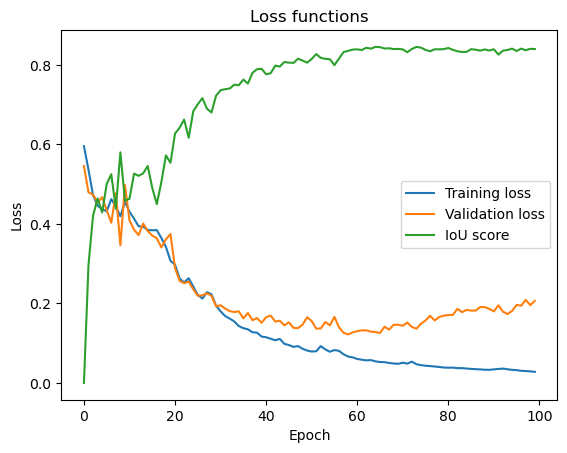


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [6/24]: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.6538 - VL_loss=0.5915 - IoU=0.0000
Epoch 2/100: TR_loss=0.5614 - VL_loss=0.5648 - IoU=0.0000
Epoch 3/100: TR_loss=0.5411 - VL_loss=0.5323 - IoU=0.0000
Epoch 4/100: TR_loss=0.4996 - VL_loss=0.4914 - IoU=0.1254
Epoch 5/100: TR_loss=0.4548 - VL_loss=0.4317 - IoU=0.3675
Epoch 6/100: TR_loss=0.4263 - VL_loss=0.4570 - IoU=0.2501
Epoch 7/100: TR_loss=0.4517 - VL_loss=0.4394 - IoU=0.4496
Epoch 8/100: TR_loss=0.4117 - VL_loss=0.3682 - IoU=0.5265
Epoch 9/100: TR_loss=0.4423 - VL_loss=0.4710 - IoU=0.4531
Epoch 10/100: TR_loss=0.4483 - VL_loss=0.4158

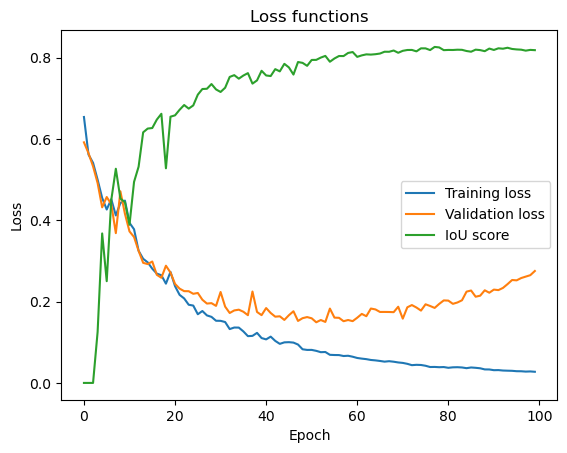


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [7/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.6767 - VL_loss=0.6477 - IoU=0.0000
Epoch 2/100: TR_loss=0.5879 - VL_loss=0.5634 - IoU=0.0000
Epoch 3/100: TR_loss=0.5439 - VL_loss=0.5111 - IoU=0.0000
Epoch 4/100: TR_loss=0.4391 - VL_loss=0.4092 - IoU=0.3101
Epoch 5/100: TR_loss=0.3738 - VL_loss=0.3615 - IoU=0.5535
Epoch 6/100: TR_loss=0.3455 - VL_loss=0.3182 - IoU=0.5521
Epoch 7/100: TR_loss=0.3469 - VL_loss=0.3395 - IoU=0.5827
Epoch 8/100: TR_loss=0.3062 - VL_loss=0.2961 - IoU=0.5779
Epoch 9/100: TR_loss=0.2869 - VL_loss=0.2978 - IoU=0.6065
Epoch 10/100: TR_loss=0.2868 - VL_loss=

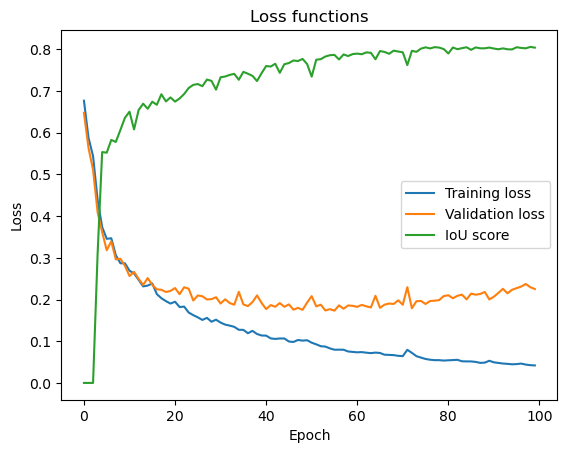


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [8/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.7259 - VL_loss=0.7120 - IoU=0.2592
Epoch 2/100: TR_loss=0.6931 - VL_loss=0.6512 - IoU=0.0019
Epoch 3/100: TR_loss=0.6051 - VL_loss=0.5748 - IoU=0.0000
Epoch 4/100: TR_loss=0.5704 - VL_loss=0.5487 - IoU=0.0000
Epoch 5/100: TR_loss=0.5502 - VL_loss=0.5300 - IoU=0.0034
Epoch 6/100: TR_loss=0.5239 - VL_loss=0.5037 - IoU=0.1483
Epoch 7/100: TR_loss=0.4678 - VL_loss=0.4109 - IoU=0.4333
Epoch 8/100: TR_loss=0.4012 - VL_loss=0.3758 - IoU=0.5002
Epoch 9/100: TR_loss=0.3681 - VL_loss=0.3466 - IoU=0.5678
Epoch 10/100: TR_loss=0.3340 - VL_loss

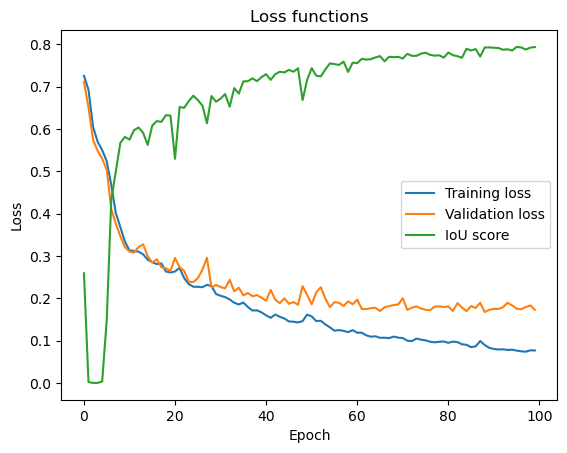


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [9/24]: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.7056 - VL_loss=0.7004 - IoU=0.2643
Epoch 2/100: TR_loss=0.6955 - VL_loss=0.6884 - IoU=0.2514
Epoch 3/100: TR_loss=0.6792 - VL_loss=0.6682 - IoU=0.0005
Epoch 4/100: TR_loss=0.6512 - VL_loss=0.6190 - IoU=0.0000
Epoch 5/100: TR_loss=0.5998 - VL_loss=0.5923 - IoU=0.0000
Epoch 6/100: TR_loss=0.5681 - VL_loss=0.5789 - IoU=0.0000
Epoch 7/100: TR_loss=0.5612 - VL_loss=0.5695 - IoU=0.0000
Epoch 8/100: TR_loss=0.5509 - VL_loss=0.5595 - IoU=0.0000
Epoch 9/100: TR_loss=0.5411 - VL_loss=0.5452 - IoU=0.0000
Epoch 10/100: TR_loss=0.5214 - VL_loss

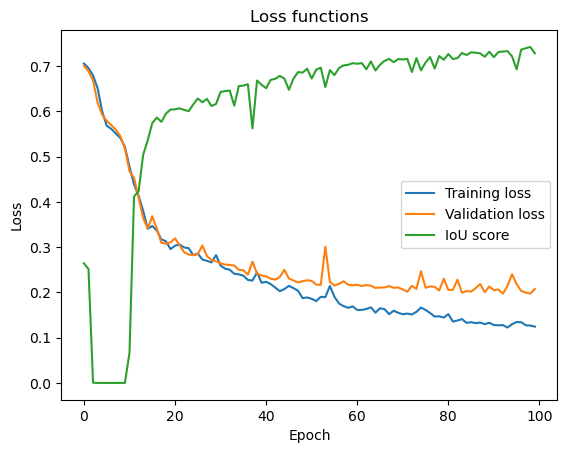


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [10/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.5461 - VL_loss=0.4453 - IoU=0.4304
Epoch 2/100: TR_loss=0.4418 - VL_loss=0.3935 - IoU=0.4757
Epoch 3/100: TR_loss=0.4971 - VL_loss=0.4405 - IoU=0.5090
Epoch 4/100: TR_loss=0.4237 - VL_loss=0.4293 - IoU=0.4837
Epoch 5/100: TR_loss=0.3853 - VL_loss=0.3711 - IoU=0.5123
Epoch 6/100: TR_loss=0.3498 - VL_loss=0.3303 - IoU=0.5408
Epoch 7/100: TR_loss=0.3262 - VL_loss=0.4155 - IoU=0.5181
Epoch 8/100: TR_loss=0.3281 - VL_loss=0.2981 - IoU=0.5418
Epoch 9/100: TR_loss=0.2945 - VL_loss=0.2840 - IoU=0.5624
Epoch 10/100: TR_loss=0.2878 - VL_loss=

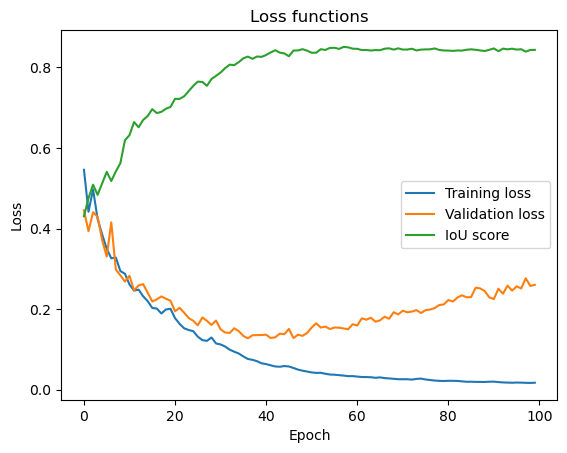


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [11/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.6302 - VL_loss=0.5435 - IoU=0.0000
Epoch 2/100: TR_loss=0.5348 - VL_loss=0.4693 - IoU=0.1387
Epoch 3/100: TR_loss=0.4436 - VL_loss=0.4176 - IoU=0.4972
Epoch 4/100: TR_loss=0.4248 - VL_loss=0.4260 - IoU=0.4992
Epoch 5/100: TR_loss=0.4184 - VL_loss=0.3914 - IoU=0.5051
Epoch 6/100: TR_loss=0.4008 - VL_loss=0.3727 - IoU=0.4475
Epoch 7/100: TR_loss=0.3916 - VL_loss=0.3993 - IoU=0.5206
Epoch 8/100: TR_loss=0.3877 - VL_loss=0.4230 - IoU=0.5018
Epoch 9/100: TR_loss=0.3864 - VL_loss=0.3643 - IoU=0.4049
Epoch 10/100: TR_loss=0.3980 - VL_loss

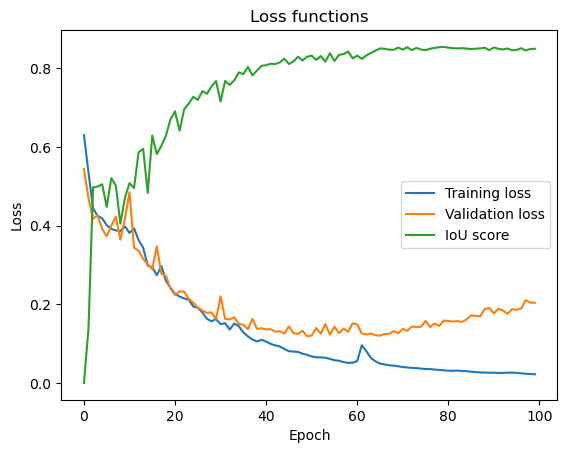


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [12/24]: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/100: TR_loss=0.7356 - VL_loss=0.6037 - IoU=0.0000
Epoch 2/100: TR_loss=0.6227 - VL_loss=0.6133 - IoU=0.0000
Epoch 3/100: TR_loss=0.5797 - VL_loss=0.5812 - IoU=0.0000
Epoch 4/100: TR_loss=0.5757 - VL_loss=0.5650 - IoU=0.4289
Epoch 5/100: TR_loss=0.5372 - VL_loss=0.5259 - IoU=0.0051
Epoch 6/100: TR_loss=0.4856 - VL_loss=0.4788 - IoU=0.3204
Epoch 7/100: TR_loss=0.4330 - VL_loss=0.4479 - IoU=0.3868
Epoch 8/100: TR_loss=0.4488 - VL_loss=0.4162 - IoU=0.3000
Epoch 9/100: TR_loss=0.4117 - VL_loss=0.4074 - IoU=0.4545
Epoch 10/100: TR_loss=0.3896 - VL_loss

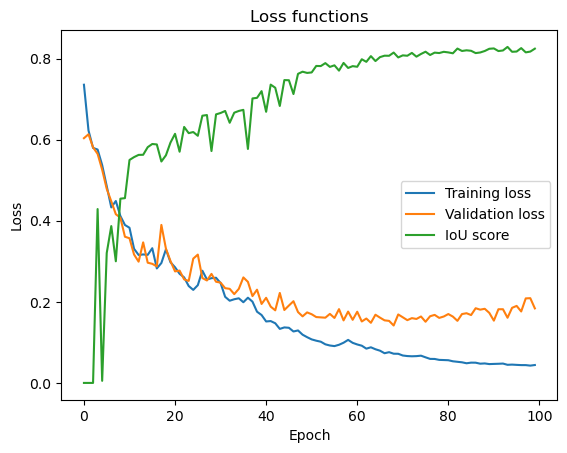


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [13/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.6449 - VL_loss=0.6199 - IoU=0.0000
Epoch 2/100: TR_loss=0.5758 - VL_loss=0.5543 - IoU=0.0000
Epoch 3/100: TR_loss=0.5418 - VL_loss=0.5306 - IoU=0.0000
Epoch 4/100: TR_loss=0.4701 - VL_loss=0.4000 - IoU=0.3114
Epoch 5/100: TR_loss=0.3662 - VL_loss=0.3175 - IoU=0.6063
Epoch 6/100: TR_loss=0.3135 - VL_loss=0.2858 - IoU=0.6128
Epoch 7/100: TR_loss=0.2816 - VL_loss=0.2798 - IoU=0.6289
Epoch 8/100: TR_loss=0.2816 - VL_loss=0.2828 - IoU=0.5833
Epoch 9/100: TR_loss=0.2652 - VL_loss=0.2628 - IoU=0.6228
Epoch 10/100: TR_loss=0.2706 - VL_loss=

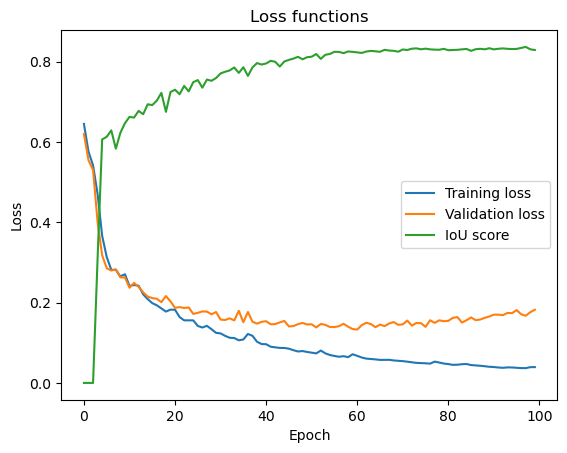


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [14/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.6854 - VL_loss=0.6758 - IoU=0.0000
Epoch 2/100: TR_loss=0.6647 - VL_loss=0.6427 - IoU=0.0000
Epoch 3/100: TR_loss=0.6176 - VL_loss=0.5734 - IoU=0.0000
Epoch 4/100: TR_loss=0.5678 - VL_loss=0.5541 - IoU=0.0000
Epoch 5/100: TR_loss=0.5520 - VL_loss=0.5246 - IoU=0.0000
Epoch 6/100: TR_loss=0.4657 - VL_loss=0.4272 - IoU=0.0071
Epoch 7/100: TR_loss=0.4219 - VL_loss=0.4110 - IoU=0.4009
Epoch 8/100: TR_loss=0.4114 - VL_loss=0.3983 - IoU=0.4751
Epoch 9/100: TR_loss=0.3896 - VL_loss=0.3679 - IoU=0.5013
Epoch 10/100: TR_loss=0.3603 - VL_loss

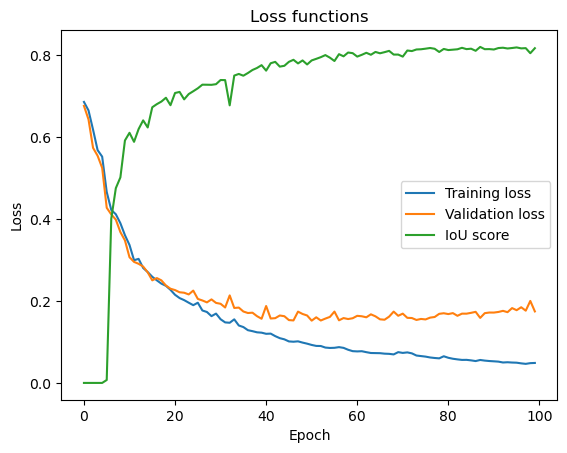


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [15/24]: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.7190 - VL_loss=0.7144 - IoU=0.2553
Epoch 2/100: TR_loss=0.7122 - VL_loss=0.7068 - IoU=0.2575
Epoch 3/100: TR_loss=0.7029 - VL_loss=0.6955 - IoU=0.2159
Epoch 4/100: TR_loss=0.6873 - VL_loss=0.6698 - IoU=0.0007
Epoch 5/100: TR_loss=0.6442 - VL_loss=0.6207 - IoU=0.0000
Epoch 6/100: TR_loss=0.5976 - VL_loss=0.5951 - IoU=0.0000
Epoch 7/100: TR_loss=0.5766 - VL_loss=0.5842 - IoU=0.0000
Epoch 8/100: TR_loss=0.5690 - VL_loss=0.5752 - IoU=0.0000
Epoch 9/100: TR_loss=0.5742 - VL_loss=0.5647 - IoU=0.0000
Epoch 10/100: TR_loss=0.5529 - VL_loss

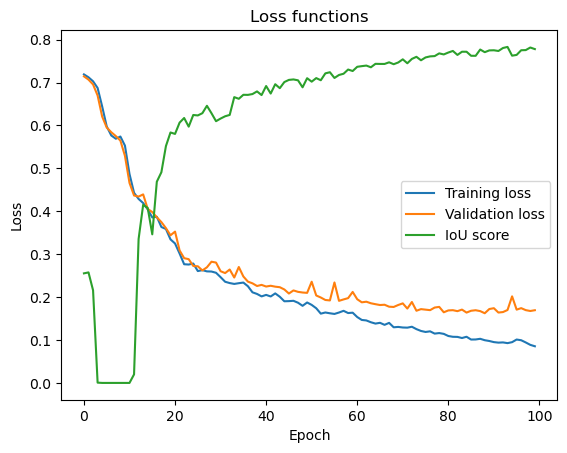


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8541343354043507
- Loss=0.3336265832185745
Hyperparameters [16/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.5874 - VL_loss=0.5304 - IoU=0.2973
Epoch 2/100: TR_loss=0.4686 - VL_loss=0.5068 - IoU=0.4547
Epoch 3/100: TR_loss=0.4322 - VL_loss=0.4063 - IoU=0.4575
Epoch 4/100: TR_loss=0.4269 - VL_loss=0.4103 - IoU=0.4787
Epoch 5/100: TR_loss=0.4224 - VL_loss=0.4094 - IoU=0.4731
Epoch 6/100: TR_loss=0.4106 - VL_loss=0.3949 - IoU=0.5182
Epoch 7/100: TR_loss=0.3920 - VL_loss=0.3764 - IoU=0.5025
Epoch 8/100: TR_loss=0.3375 - VL_loss=0.2762 - IoU=0.6323
Epoch 9/100: TR_loss=0.2844 - VL_loss=0.2994 - IoU=0.6421
Epoch 10/100: TR_loss=0.2677 - VL_loss=0

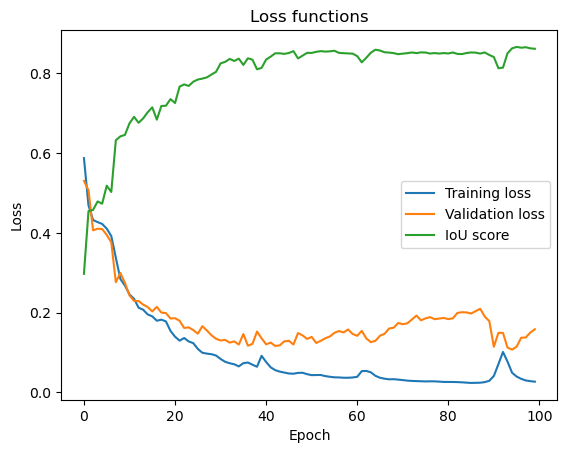


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.863391175156548
- Loss=0.15825085980551584
Hyperparameters [17/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.6286 - VL_loss=0.5397 - IoU=0.0000
Epoch 2/100: TR_loss=0.5159 - VL_loss=0.4839 - IoU=0.0337
Epoch 3/100: TR_loss=0.4682 - VL_loss=0.4802 - IoU=0.4477
Epoch 4/100: TR_loss=0.4458 - VL_loss=0.4612 - IoU=0.4477
Epoch 5/100: TR_loss=0.4253 - VL_loss=0.4096 - IoU=0.4849
Epoch 6/100: TR_loss=0.4261 - VL_loss=0.4203 - IoU=0.5292
Epoch 7/100: TR_loss=0.4159 - VL_loss=0.3714 - IoU=0.3992
Epoch 8/100: TR_loss=0.4229 - VL_loss=0.4068 - IoU=0.5092
Epoch 9/100: TR_loss=0.3713 - VL_loss=0.3805 - IoU=0.5602
Epoch 10/100: TR_loss=0.3530 - VL_

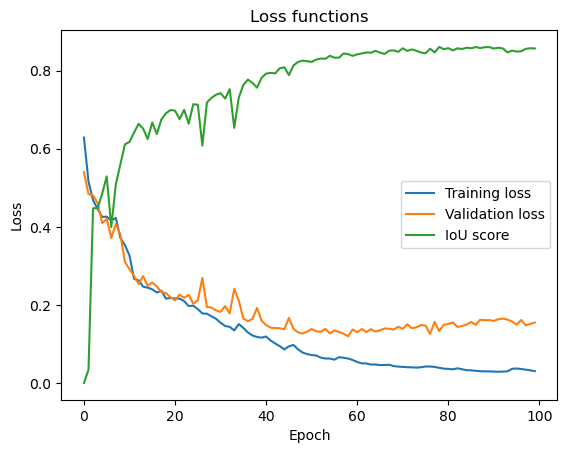


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.863391175156548
- Loss=0.15825085980551584
Hyperparameters [18/24]: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.6358 - VL_loss=0.5929 - IoU=0.0000
Epoch 2/100: TR_loss=0.5699 - VL_loss=0.5696 - IoU=0.0000
Epoch 3/100: TR_loss=0.5526 - VL_loss=0.5304 - IoU=0.0000
Epoch 4/100: TR_loss=0.4799 - VL_loss=0.4720 - IoU=0.0000
Epoch 5/100: TR_loss=0.4605 - VL_loss=0.4201 - IoU=0.0000
Epoch 6/100: TR_loss=0.3829 - VL_loss=0.3751 - IoU=0.5248
Epoch 7/100: TR_loss=0.3675 - VL_loss=0.3880 - IoU=0.3050
Epoch 8/100: TR_loss=0.3780 - VL_loss=0.3894 - IoU=0.5201
Epoch 9/100: TR_loss=0.3509 - VL_loss=0.3156 - IoU=0.5620
Epoch 10/100: TR_loss=0.3020 - VL_

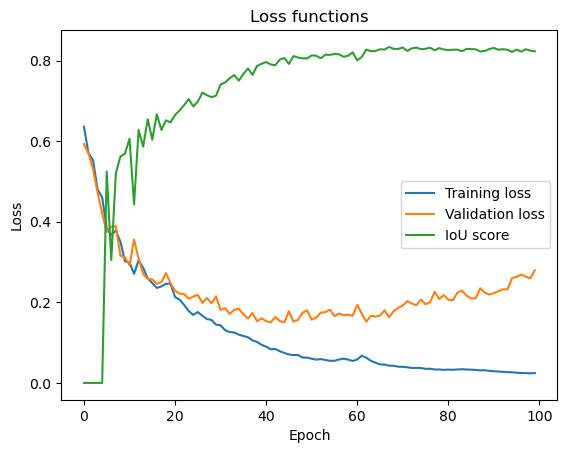


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.863391175156548
- Loss=0.15825085980551584
Hyperparameters [19/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.7041 - VL_loss=0.6573 - IoU=0.0031
Epoch 2/100: TR_loss=0.5933 - VL_loss=0.5665 - IoU=0.0000
Epoch 3/100: TR_loss=0.5444 - VL_loss=0.5475 - IoU=0.0000
Epoch 4/100: TR_loss=0.4850 - VL_loss=0.3996 - IoU=0.5103
Epoch 5/100: TR_loss=0.3734 - VL_loss=0.3762 - IoU=0.5624
Epoch 6/100: TR_loss=0.3431 - VL_loss=0.3113 - IoU=0.5805
Epoch 7/100: TR_loss=0.3008 - VL_loss=0.2807 - IoU=0.6144
Epoch 8/100: TR_loss=0.2861 - VL_loss=0.2811 - IoU=0.6188
Epoch 9/100: TR_loss=0.2750 - VL_loss=0.2688 - IoU=0.6427
Epoch 10/100: TR_loss=0.2635

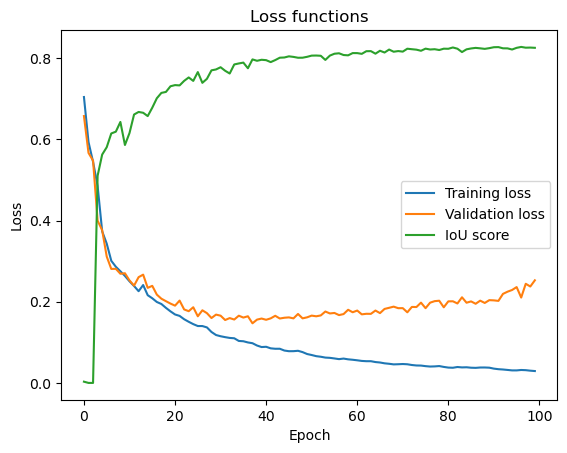


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.863391175156548
- Loss=0.15825085980551584
Hyperparameters [20/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.6835 - VL_loss=0.6762 - IoU=0.0000
Epoch 2/100: TR_loss=0.6685 - VL_loss=0.6536 - IoU=0.0000
Epoch 3/100: TR_loss=0.6185 - VL_loss=0.5823 - IoU=0.0000
Epoch 4/100: TR_loss=0.5679 - VL_loss=0.5561 - IoU=0.0000
Epoch 5/100: TR_loss=0.5300 - VL_loss=0.4844 - IoU=0.0000
Epoch 6/100: TR_loss=0.4419 - VL_loss=0.4108 - IoU=0.0452
Epoch 7/100: TR_loss=0.4085 - VL_loss=0.3878 - IoU=0.4416
Epoch 8/100: TR_loss=0.3747 - VL_loss=0.3455 - IoU=0.5745
Epoch 9/100: TR_loss=0.3478 - VL_loss=0.3429 - IoU=0.4988
Epoch 10/100: TR_loss=0.322

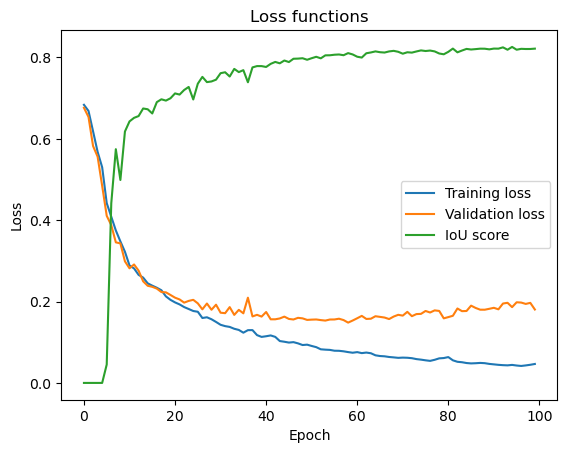


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.863391175156548
- Loss=0.15825085980551584
Hyperparameters [21/24]: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.6939 - VL_loss=0.6885 - IoU=0.0198
Epoch 2/100: TR_loss=0.6844 - VL_loss=0.6778 - IoU=0.0000
Epoch 3/100: TR_loss=0.6685 - VL_loss=0.6592 - IoU=0.0000
Epoch 4/100: TR_loss=0.6376 - VL_loss=0.6116 - IoU=0.0000
Epoch 5/100: TR_loss=0.5969 - VL_loss=0.5882 - IoU=0.0000
Epoch 6/100: TR_loss=0.5758 - VL_loss=0.5760 - IoU=0.0000
Epoch 7/100: TR_loss=0.5536 - VL_loss=0.5676 - IoU=0.0000
Epoch 8/100: TR_loss=0.5493 - VL_loss=0.5488 - IoU=0.0000
Epoch 9/100: TR_loss=0.5272 - VL_loss=0.5527 - IoU=0.0000
Epoch 10/100: TR_loss=0.539

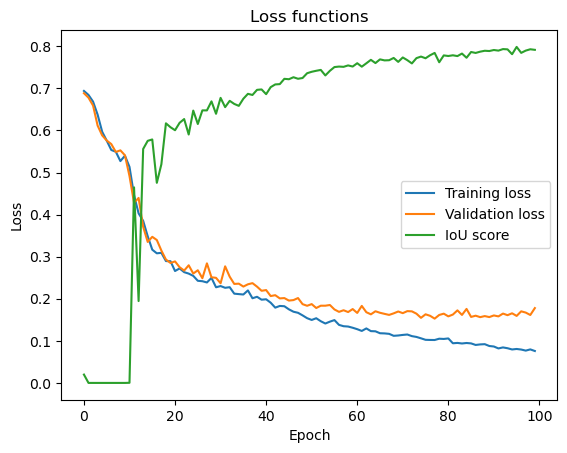


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.863391175156548
- Loss=0.15825085980551584
Hyperparameters [22/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.6024 - VL_loss=0.5051 - IoU=0.2118
Epoch 2/100: TR_loss=0.4906 - VL_loss=0.4523 - IoU=0.4276
Epoch 3/100: TR_loss=0.4348 - VL_loss=0.4004 - IoU=0.4899
Epoch 4/100: TR_loss=0.4138 - VL_loss=0.3838 - IoU=0.4468
Epoch 5/100: TR_loss=0.3822 - VL_loss=0.3985 - IoU=0.5228
Epoch 6/100: TR_loss=0.3465 - VL_loss=0.3572 - IoU=0.4603
Epoch 7/100: TR_loss=0.3000 - VL_loss=0.3590 - IoU=0.3853
Epoch 8/100: TR_loss=0.2740 - VL_loss=0.3066 - IoU=0.4742
Epoch 9/100: TR_loss=0.2719 - VL_loss=0.2597 - IoU=0.6470
Epoch 10/100: TR_loss=0.2457 

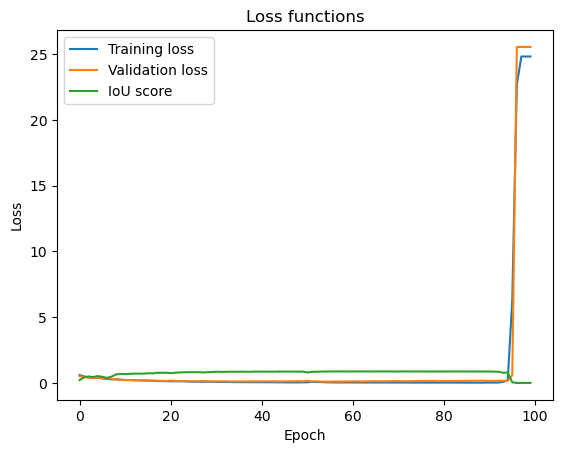


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.863391175156548
- Loss=0.15825085980551584
Hyperparameters [23/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.6599 - VL_loss=0.5768 - IoU=0.0000
Epoch 2/100: TR_loss=0.5360 - VL_loss=0.7874 - IoU=0.3418
Epoch 3/100: TR_loss=0.5022 - VL_loss=0.4620 - IoU=0.0000
Epoch 4/100: TR_loss=0.4499 - VL_loss=0.4304 - IoU=0.3777
Epoch 5/100: TR_loss=0.4403 - VL_loss=0.4113 - IoU=0.5078
Epoch 6/100: TR_loss=0.4244 - VL_loss=0.3923 - IoU=0.5208
Epoch 7/100: TR_loss=0.4131 - VL_loss=0.3842 - IoU=0.4501
Epoch 8/100: TR_loss=0.4117 - VL_loss=0.4157 - IoU=0.3845
Epoch 9/100: TR_loss=0.4089 - VL_loss=0.3858 - IoU=0.5242
Epoch 10/100: TR_loss=0.3975

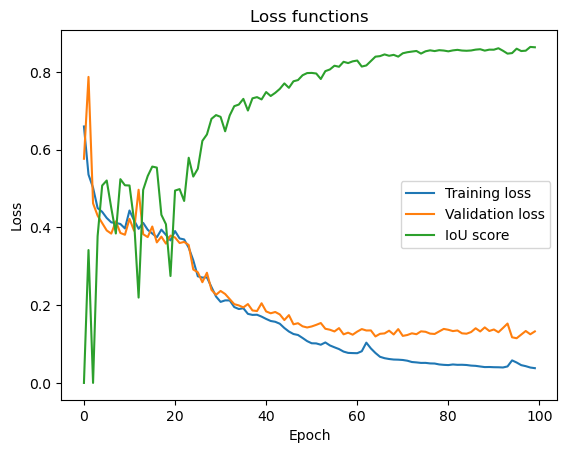


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.863391175156548
- Loss=0.15825085980551584
Hyperparameters [24/24]: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'leaky_relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/100: TR_loss=0.6608 - VL_loss=0.5819 - IoU=0.0000
Epoch 2/100: TR_loss=0.5749 - VL_loss=0.5563 - IoU=0.0000
Epoch 3/100: TR_loss=0.5164 - VL_loss=0.4992 - IoU=0.0905
Epoch 4/100: TR_loss=0.4578 - VL_loss=0.4443 - IoU=0.3602
Epoch 5/100: TR_loss=0.4417 - VL_loss=0.4207 - IoU=0.5049
Epoch 6/100: TR_loss=0.4392 - VL_loss=0.4255 - IoU=0.4457
Epoch 7/100: TR_loss=0.4472 - VL_loss=0.4333 - IoU=0.4441
Epoch 8/100: TR_loss=0.4072 - VL_loss=0.3804 - IoU=0.4048
Epoch 9/100: TR_loss=0.3631 - VL_loss=0.3059 - IoU=0.5775
Epoch 10/100: TR_loss=0.3692

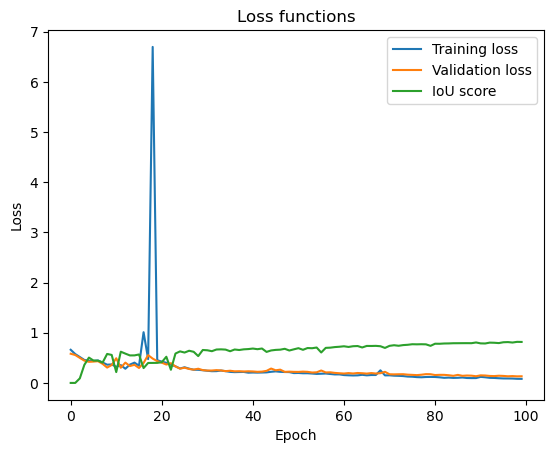


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.863391175156548
- Loss=0.15825085980551584


In [ ]:
def show_plots(values_list: list[list], labels: list[str]):
    for i, values in enumerate(values_list):
        plt.plot(values, label=labels[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss functions')
    plt.show()


# Iterates on each parameters combination obtained from the parameters space
tr_dataset, vl_dataset, ts_dataset = random_split(horse_dataset, [0.70,0.15,0.15])
params_list = get_params_combinations(params_space)
models = {}
best_model_obj = {'iou_scores': [0]}
for i, params in enumerate(params_list):
    print(f'Hyperparameters [{i+1}/{len(params_list)}]: {params}')

    # Datasets initializations
    tr_loader = DataLoader(tr_dataset, batch_size=params['batch_size'], shuffle=True)
    vl_loader = DataLoader(vl_dataset, batch_size=params['batch_size'], shuffle=False)

    # Create the model
    #model = SegmentationCNN(**params['architecture'])
    model = UNet(kernel_size=params['kernel_size'], features=params['features'], activation=params['activation'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = torch.nn.BCELoss()

    # Training phase
    tr_losses, vl_losses, iou_scores = train(
        model,
        tr_dataloader=tr_loader,
        vl_dataloader=vl_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        epochs=params['epochs'],
        threshold=params['threshold'],
        tolerance=params['tolerance'],
        verbose=2
    )

    # Insert the model in the dictionary
    models[i] = {
        'model': model,
        'params': params,
        'vl_losses': vl_losses,
        'tr_losses': tr_losses,
        'iou_scores': iou_scores
    }

    # Shows the Loss plots
    show_plots(
        values_list=[tr_losses,vl_losses,iou_scores],
        labels=['Training loss','Validation loss','IoU score']
    )

    # Save the model if it is the best one (based on the highest IoU score)
    mean_iou_best_score = np.mean(best_model_obj['iou_scores'][-3:])
    mean_iou_score = np.mean(iou_scores[-3:])
    if mean_iou_best_score < mean_iou_score:
        best_model_obj = models[i]
    print(f'\nBest model:\n- Hyperparameters={best_model_obj["params"]}\n- IoU score={np.mean(best_model_obj["iou_scores"][-3:])}\n- Loss={best_model_obj["vl_losses"][-1]}')



## Model evaluation

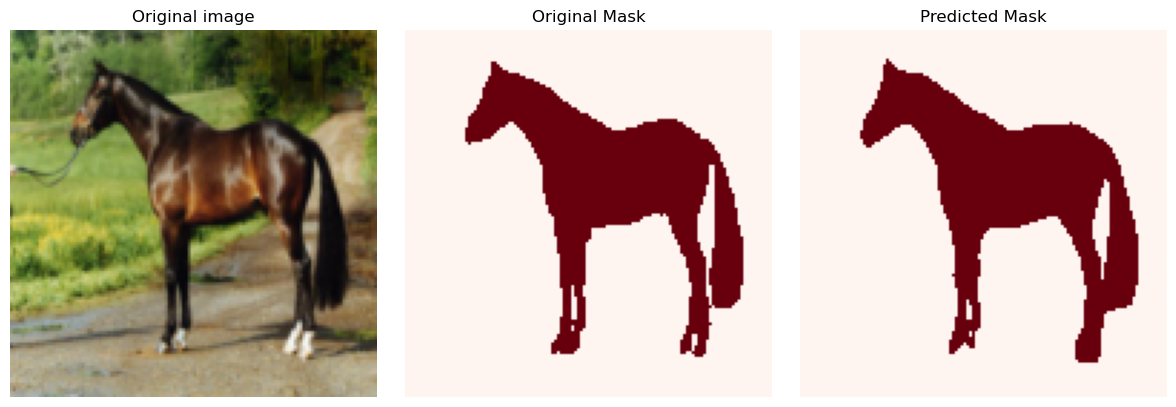

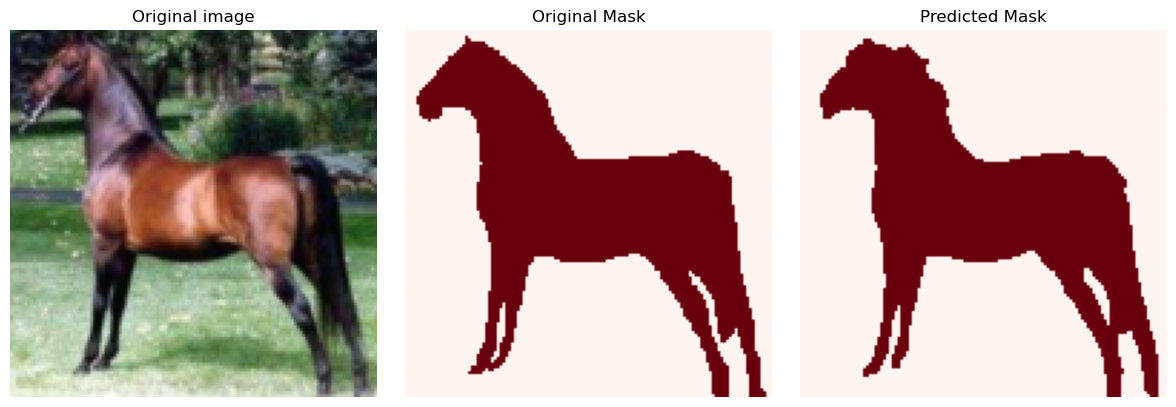

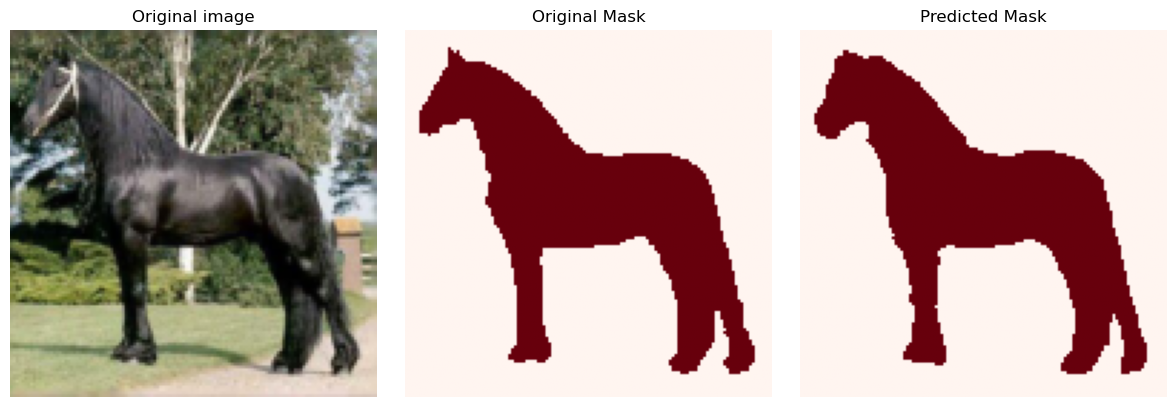

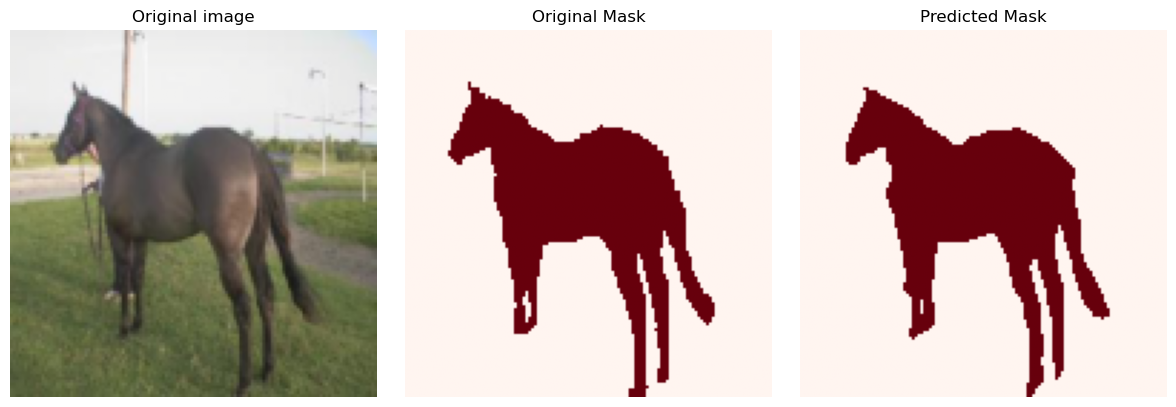

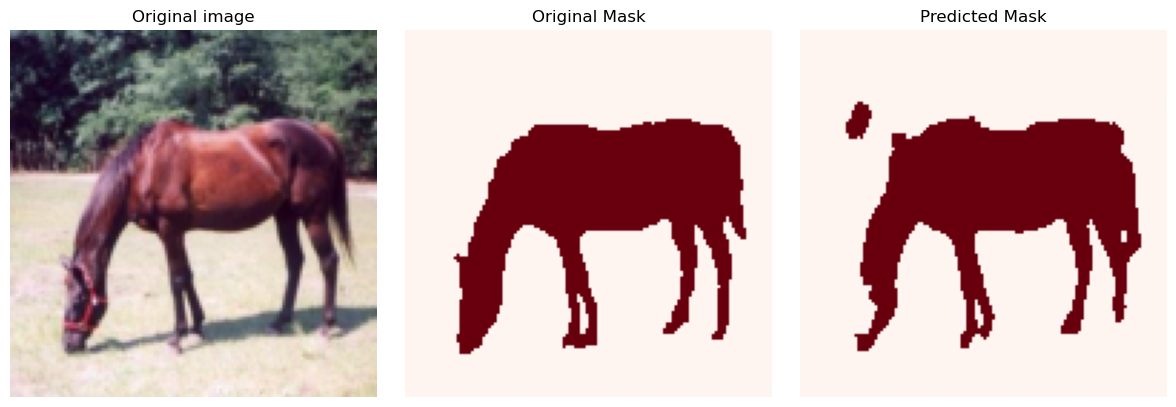

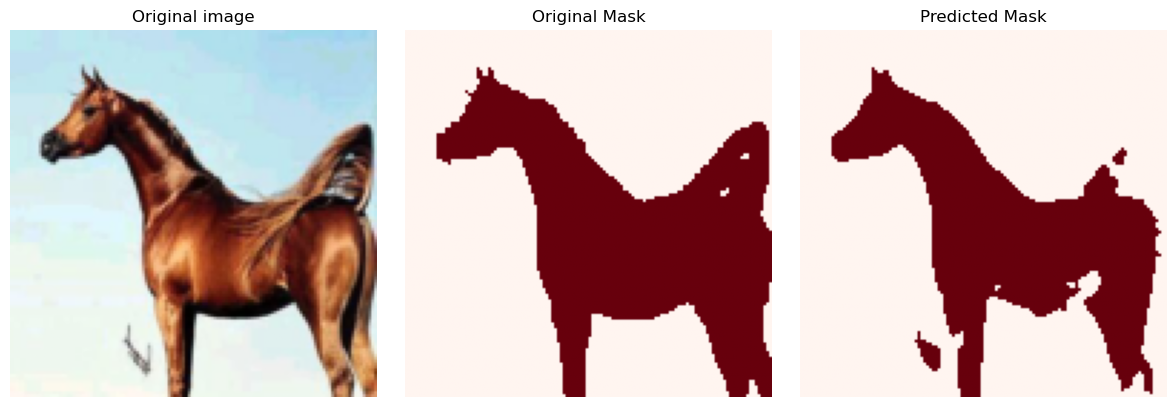

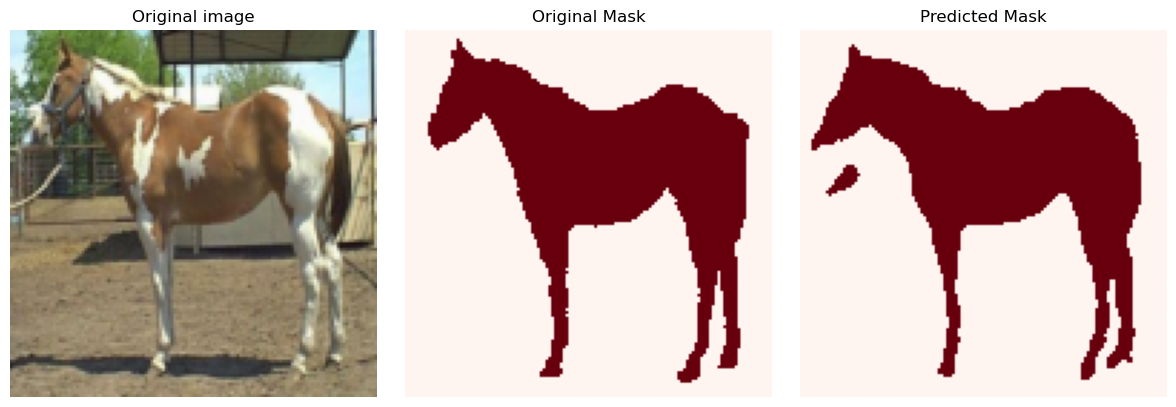

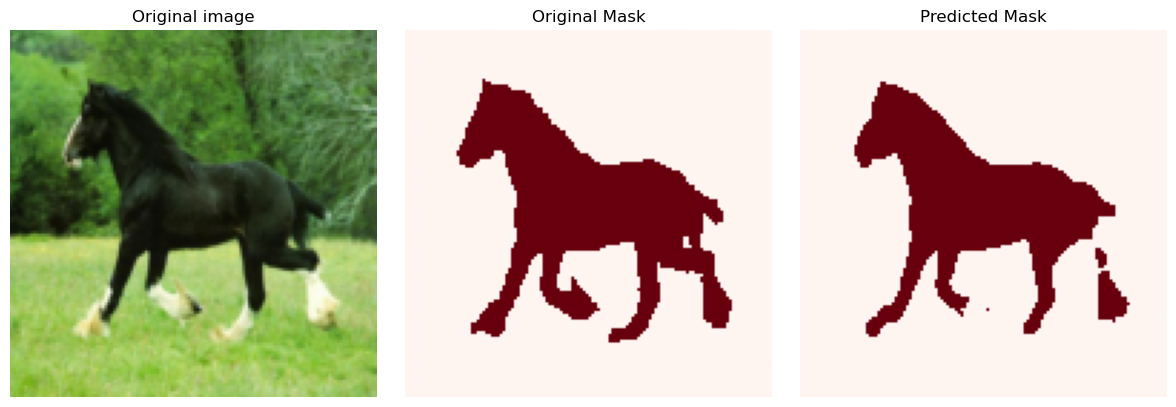

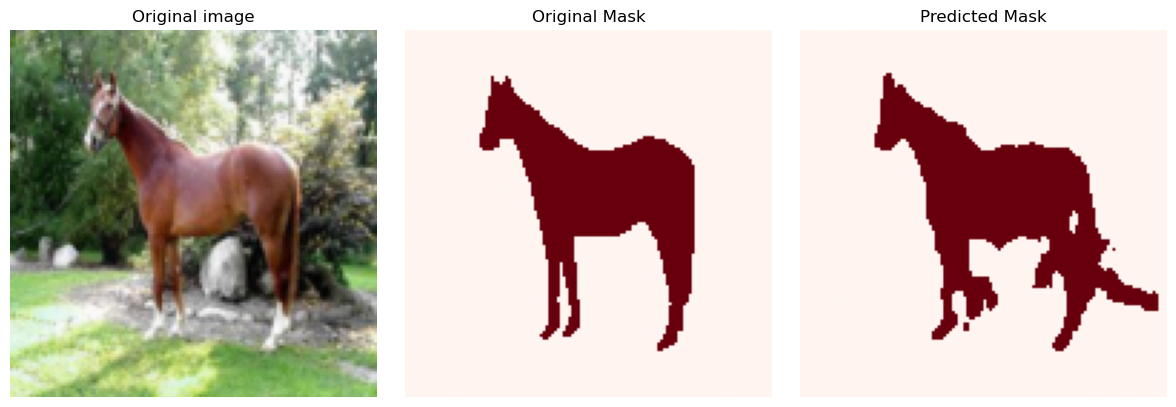

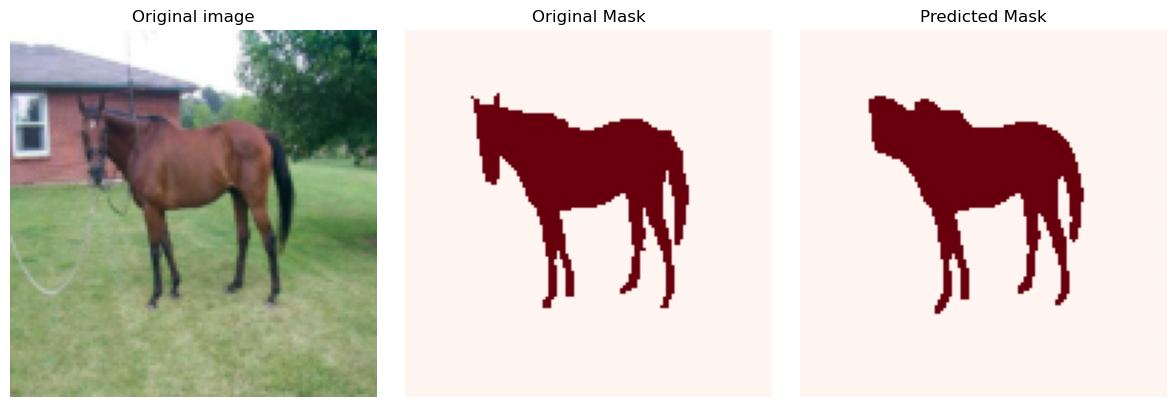

Best model parameters: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 100, 'threshold': 0.001, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Test Loss: 0.17112045415810176
Test IoU score: 0.8649799483163017


In [ ]:
def show_prediction_plot(img, mask, pred):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title('Original image')
    axs[0].axis('off')
    axs[1].imshow(mask, cmap='Reds')
    axs[1].set_title('Original Mask')
    axs[1].axis('off')
    axs[2].imshow(pred, cmap='Reds')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()



def denormalize(img: torch.Tensor, dataset: Dataset) -> torch.Tensor:
    mean, std = dataset.mean, dataset.std
    for tensor, m, s in zip(img, mean, std):
        tensor.mul_(s).add_(m)
    return img



def evaluate(model: nn.Module, ts_dataloader: DataLoader, criterion, device, n_imgs_to_show=10):
    model.eval()
    model.to(device)

    # Initializations
    total_loss = 0.0
    total_iou = 0.0
    shown = 0

    with torch.no_grad():
        for imgs, masks in ts_dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Compute the predictions and the loss
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item()

            # Binarization of the predictions
            preds = (preds > 0.5).float()

            # Case of plot of the images
            if shown < n_imgs_to_show:
                # Matplotlib can't handle GPU tensors (so we need to move them to CPU)
                imgs_cpu = imgs.cpu()
                masks_cpu = masks.cpu()
                preds_cpu = preds.cpu()
                # Plot the images
                for img, mask, pred in zip(imgs_cpu, masks_cpu, preds_cpu):
                    mask = (mask > 0.5).float()
                    pred = (pred > 0.5).float()
                    if shown == n_imgs_to_show:
                        break
                    img = denormalize(img, dataset)
                    show_prediction_plot(img.permute(1,2,0), mask[0], pred[0])
                    shown += 1

            # Compute the number of correct pixels predicted
            total_iou += iou(preds, masks)

    # Accuracy and average loss
    iou_avg_score = total_iou / len(ts_dataloader)
    avg_loss = total_loss / len(ts_dataloader)
    return iou_avg_score, avg_loss



# Create the test dataloader
ts_loader = DataLoader(ts_dataset, batch_size=best_model_obj['params']['batch_size'], shuffle=False)

# Evaluation phase
iou_score, avg_loss = evaluate(
    model=best_model_obj['model'],
    ts_dataloader=ts_loader,
    criterion=criterion,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Show the results
print(f'Best model parameters: {best_model_obj["params"]}')
print(f'Test Loss: {avg_loss}')
print(f'Test IoU score: {iou_score}')
show_plots(
    values_list=[best_model_obj['tr_losses'], best_model_obj['vl_losses'], best_model_obj['iou_scores']],
    labels=['Training loss', 'Validation loss', 'IoU score']
)